In [0]:
!python mlip_setup_env.py
!pip install webdavclient3

Initialized empty Git repository in /content/.git/
Updating origin
remote: Enumerating objects: 847, done.
remote: Total 847 (delta 0), reused 0 (delta 0), pack-reused 847
Receiving objects: 100% (847/847), 7.84 MiB | 1.29 MiB/s, done.
Resolving deltas: 100% (507/507), done.
From https://github.com/L-Hess/CS4180-Deep-Learning--CNN
 * [new branch]      master     -> origin/master
Branch 'master' set up to track remote branch 'master' from 'origin'.
Already on 'master'
Changing working directory to code/hw1!
Data not present, retrieving...
 99% 977M/986M [00:10<00:00, 105MB/s]
100% 986M/986M [00:10<00:00, 97.8MB/s]
  0% 0.00/1.70k [00:00<?, ?B/s]
100% 1.70k/1.70k [00:00<00:00, 1.43MB/s]
  0% 0.00/4.75k [00:00<?, ?B/s]
100% 4.75k/4.75k [00:00<00:00, 4.83MB/s]
 99% 983M/992M [00:15<00:00, 65.9MB/s]
100% 992M/992M [00:15<00:00, 67.4MB/s]
  0% 0.00/1.28M [00:00<?, ?B/s]
100% 1.28M/1.28M [00:00<00:00, 185MB/s]
  0% 0.00/4.72k [00:00<?, ?B/s]
100% 4.72k/4.72k [00:00<00:00, 15.9MB/s]
  0% 0.00/

In [0]:
cd code/hw1/

/content/code/hw1


In [0]:
%tensorflow_version 2.x

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Lambda, Dense, Conv2D, Flatten
from tensorflow.keras.layers import MaxPool2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model, clone_model
from tensorflow.keras.optimizers import SGD

from starter_eda_model_funcs import MultiOutputDataGenerator, get_model
from helper import to_one_hot, preview_data_aug
from preprocessing import perform_preprocessing
from flow import generators_from_prep, generator_wrapper, train
from flow import get_lr_test_scheduler, get_pyramid_lr

# further settings
FIG_DIR = 'results/generated_figs/'
plt.rcParams["figure.figsize"] = (10, 4.5) # set higher on 4k monitor
plt.rcParams["savefig.format"] = "pdf"
plt.rcParams["savefig.dpi"] = 400
plt.rcParams["savefig.transparent"] = True
plt.rcParams.update({'font.size': 16})
plt.rcParams["savefig.bbox"] = 'tight'

TensorFlow 2.x selected.


In [0]:
from webdav3.client import Client

options = {
 'webdav_hostname': "https://joeranbosma.stackstorage.com/remote.php/webdav",
 'webdav_login':    "",
 'webdav_password':  ""
}
client = Client(options)

In [0]:
!pip install efficientnet

In [0]:
import efficientnet.tfkeras
import efficientnet.tfkeras as efn
import tensorflow as tf

# Generalized mean pool - GeM
gm_exp = tf.Variable(3.0, dtype = tf.float32)
def generalized_mean_pool_2d(X):
    pool = (tf.reduce_mean(tf.abs(X**(gm_exp)), 
                        axis = [1, 2], 
                        keepdims = False) + 1.e-7)**(1./gm_exp)
    return pool

In [0]:
# Create Model
def create_model_eff(input_shape, effnet='B0', optimizer='Adam', loss_weights=[0.4, 0.3, 0.3]):
    # Input Layer
    inp = Input(shape = input_shape)
    
    # Create and Compile Model and show Summary
    kwargs = dict(weights = None, include_top = False, input_tensor = inp, pooling = None, classes = None)
    if effnet == 'B0':
        x_model = efn.EfficientNetB0(**kwargs)
    elif effnet == 'B1':
        x_model = efn.EfficientNetB1(**kwargs)
    elif effnet == 'B2':
        x_model = efn.EfficientNetB2(**kwargs)
    elif effnet == 'B3':
        x_model = efn.EfficientNetB3(**kwargs)
    elif effnet == 'B4':
        x_model = efn.EfficientNetB4(**kwargs)
    elif effnet == 'B5':
        x_model = efn.EfficientNetB5(**kwargs)
    elif effnet == 'B6':
        x_model = efn.EfficientNetB6(**kwargs)
        
    
    # UnFreeze all layers
    for layer in x_model.layers:
        layer.trainable = True
    
    # GeM
    lambda_layer = Lambda(generalized_mean_pool_2d)
    lambda_layer.trainable_weights.extend([gm_exp])
    x = lambda_layer(x_model.output)
    
    # multi output
    grapheme_root = Dense(168, activation = 'softmax', name = 'out_root')(x)
    vowel_diacritic = Dense(11, activation = 'softmax', name = 'out_vowel')(x)
    consonant_diacritic = Dense(7, activation = 'softmax', name = 'out_consonant')(x)

    # model
    model = Model(inputs = x_model.input, outputs = [grapheme_root, vowel_diacritic, consonant_diacritic])

    # compile
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'],
                loss_weights=loss_weights)

    return model

# Cyclical Learning Rate

In [0]:
datagen_args = dict(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=8,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.15, # Randomly zoom image 
    width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False,
    shear_range=8, #Shear Intensity (Shear angle in counter-clockwise direction in degrees)
)

roi_size = 96
pad_size = 5
cross_val_parts = 8 # for 12.5% validation data and 87.5% train data
cross_val_num = 0 # which part (shuffled) from [0, ..., n-1]

preprocess_args = dict(
    image_width=roi_size + pad_size*2,
    image_height=roi_size + pad_size*2,
    padding=pad_size,
    cross_val_num=cross_val_num,
    cross_val_parts=cross_val_parts,
)

data_path = 'Data/'
prep_path = f"Data/prep/prep_{roi_size}_{pad_size}/"

## Learning rate test with Nesterov momentum of 0.75
Increase the learning rate from 0 to 2 in 40 epochs. This gives a slope of ~0.05 per epoch.  
See result: https://app.wandb.ai/joeranbosma/mlip/runs/1mdjbaak?workspace=user-joeranbosma

In [0]:
from tensorflow.keras.optimizers import SGD

epochs = 40
batch_size = 256

name      = f"EfficientNetB0-CLR-test-2_0-nest-momentum-40-BS{batch_size}"
model_path = f'Model/{name}/'
external_path = f'models/{name}/'
lr_scheduler = get_lr_test_scheduler(lr_start=0.1, lr_end=2.0, num=epochs)

optimizer = SGD(momentum=0.75, nesterov=True)
img_size = preprocess_args['image_width']
model = create_model_eff(input_shape=(img_size, img_size, 1), effnet='B0', optimizer=optimizer, loss_weights=[0.4, 0.3, 0.3])

The following Variables were used a Lambda layer's call (lambda_1), but
are not present in its tracked objects:
  <tf.Variable 'Variable:0' shape=() dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


Start training of EfficientNetB0-CLR-test-2_0-nest-momentum-40-BS256...
Converting grapheme_root to one-hot encoding
Converting vowel_diacritic to one-hot encoding
Converting consonant_diacritic to one-hot encoding
Found 175735 validated image filenames.
Found 25105 validated image filenames.


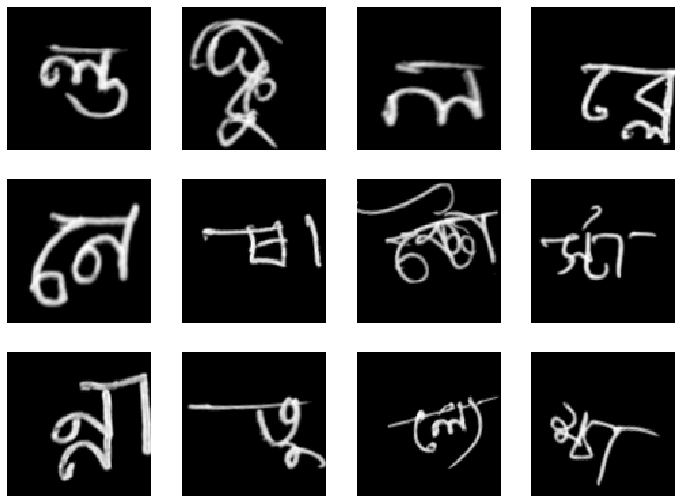

  {'out_root': '...', 'out_vowel': '...', 'out_consonant': '...'}
    to  
  ['...', '...', '...']
  {'out_root': '...', 'out_vowel': '...', 'out_consonant': '...'}
    to  
  ['...', '...', '...']
Train for 686 steps, validate for 98 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 0.1.
685/686 [============================>.] - ETA: 0s - loss: 2.6327 - out_root_loss: 4.5800 - out_vowel_loss: 1.5404 - out_consonant_loss: 1.1286 - out_root_acc: 0.0482 - out_vowel_acc: 0.4667 - out_consonant_acc: 0.6406WARNING:tensorflow:sample_weight modes were coerced from
  {'out_root': '...', 'out_vowel': '...', 'out_consonant': '...'}
    to  
  ['...', '...', '...']
686/686 [==============================] - 698s 1s/step - loss: 2.6317 - out_root_loss: 4.5791 - out_vowel_loss: 1.5391 - out_consonant_loss: 1.1277 - out_root_acc: 0.0483 - out_vowel_acc: 0.4668 - out_consonant_acc: 0.6407 - val_loss: 2.1032 - val_out_root_loss: 4.0322 - val_out_vowel_loss: 0.9404 - val_out_consonan

In [12]:
# train model
print(f"Start training of {name}...")
model = train(name = name, prep_path=prep_path, data_path=data_path,
                model_path=model_path, datagen_args = datagen_args,
                preprocess_args = preprocess_args, cross_val_parts = cross_val_parts,
                cross_val_num = cross_val_num, epochs=epochs, lr_scheduler_func=lr_scheduler, 
                webdav_client=client, min_epoch_upload=1, model=model,
                external_path=external_path, batch_size=batch_size)